For now just work with this dataset.
Will figure out the multivariate stuff later.

# Goal
The purpose of this project is to explore the demand behind flight tickets and seek to predict ticket demand in the near future. To that end, a Google trends data is studied.
The google search for plane ticket is a proxy for the market demand, thus reducing the need for extensive data collection. Since this report is to conclude a time series project, no expensive dataset gathering process is required.
From the business perspective, unraveling the patterns of past demad data is useful to forecast future demands. An accurate model of this trend drives profit, as airlines can charge more in when flight tickets are in high-demand, which should, by logical deduction, be reflected in the amount of google search of this term.  

From the consumer standpoint, knowing the patterns, perhaps especially the seasonal component, is beneficial. One may be able to save money by making plans in accordance to the flight ticket demand. The assumption that airlines will upcharge at certain times and downcharge at others gives people who plan future trips a real advantage.

# Data Preparation
The data is taken from Google Trends. The unit of measurement, the search term "plane tickets", is the popularity of the term relative to others on Goolge Trends.

A value of 100 is the peak popularity for the term.
A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term.




In [ ]:
# load packages

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose as sd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import range_unit_root_test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [ ]:
"""
To access the below analysis,

(1) Go to Google trends and download the
plane tickets trend data to your local computer file of your choice.

(2) Rename file as sta137_final_project.csv

(3) Then, upload to the file tab on the left of the colab notebook, under /content/
"""
data = pd.read_csv("/content/sta137_final_project.csv", header=1) # set header=1 for naming purposes
data.head(10)

,Month,plane tickets: (United States)
0,2004-01,79
1,2004-02,80
2,2004-03,80
3,2004-04,74
4,2004-05,78
5,2004-06,89
6,2004-07,80
7,2004-08,71
8,2004-09,78
9,2004-10,73


In [ ]:
""""
# mounting my google drive to make my life easier
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# lizzy's path
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/STA 137/sta137_final_project.csv', header=1)
"""

'"\n# mounting my google drive to make my life easier\nfrom google.colab import drive\ndrive.mount(\'/content/drive\', force_remount=True)\n# lizzy\'s path\ndata = pd.read_csv(\'/content/drive/MyDrive/Colab Notebooks/STA 137/sta137_final_project.csv\', header=1)\n'

In [ ]:
data.columns = ["time", "plane_tickets"]

data["time"] = pd.to_datetime(data["time"])

# Make a new column of the index to avoid the problem of timestamp data.
data["index"] = data.index
data

,time,plane_tickets,index
0,2004-01-01,79,0
1,2004-02-01,80,1
2,2004-03-01,80,2
3,2004-04-01,74,3
4,2004-05-01,78,4
...,...,...,...
234,2023-07-01,52,234
235,2023-08-01,44,235
236,2023-09-01,41,236
237,2023-10-01,42,237


df is another DataFrame, but with index and plane tickets

# Exploratory Data Analysis

#### misc stuff (can ignore)

In [ ]:
df = pd.DataFrame([])
df = pd.concat([data["index"], data["plane_tickets"]], axis=1, names=["index", "plane_tickets"])

Basic data dimensions

In [ ]:
print(f"The dimension in the original data is {df.shape}")

The dimension in the original data is (239, 2)


In [ ]:
df.plane_tickets.describe()

count    239.000000
mean      59.669456
std       14.038795
min       28.000000
25%       50.000000
50%       56.000000
75%       68.000000
max      100.000000
Name: plane_tickets, dtype: float64

The general description of plane ticket interest is:
1. Mean is roughly 59.7
2. Standard deviation is roughly 14
3. 25th percentile and 75th percentile are 50 and 68
4. Median is roughly 56
5. Max and min are 100 and 28

We then make special datetime formats

In [ ]:
#breakdown = pd.DataFrame(data.time.value_counts())
#breakdown

data['yy-mm'] = pd.to_datetime(data['time']).dt.strftime('%Y-%m')
data['year'] = pd.to_datetime(data['time']).dt.strftime('%Y')
data['month'] = pd.to_datetime(data['time']).dt.strftime('%m')

# Visualizations

### Time series

In [ ]:
# Plotting can be repetitive. Here's a function that automates the process.

def plot_time_series(df, x, y, title, xlabel, ylabel, compare=False, y2=None, ylabel2=None, color="blue"):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
    sns.lineplot(data=df, x=df[x], y=df[y], color=color, ax=ax)
    # For comparisons:
    if compare == True:
      plt.plot(df[y2], label=ylabel2, color = 'red')
      plt.title("Actual vs Predicted Plane Ticket Interest over Time")
    else:
      plt.title(title)
    plt.xlabel(xlabel)
    plt.legend()
    plt.ylabel(ylabel)
    plt.rc({'font.size': 16})
    plt.tight_layout()
    plt.show()

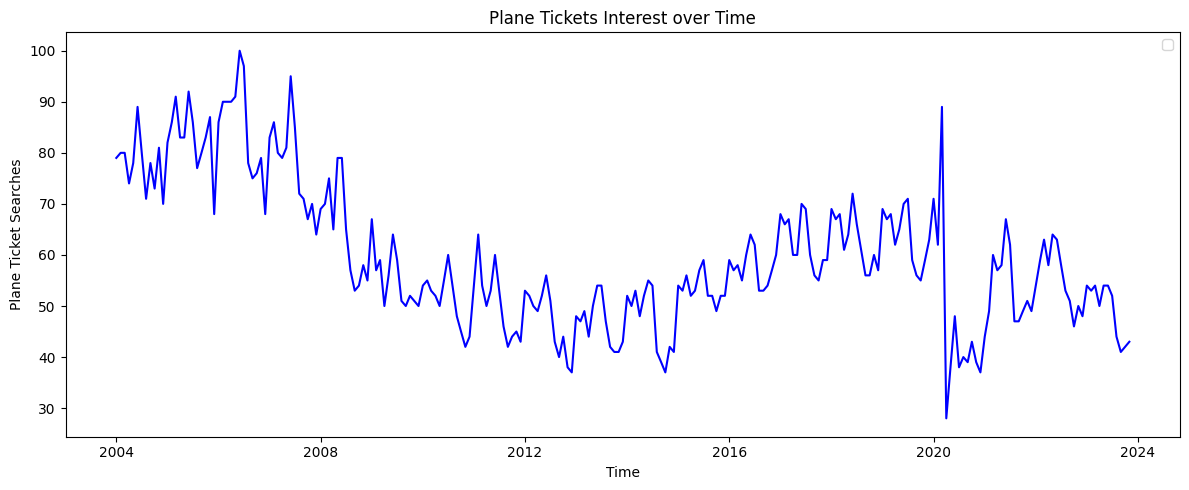

In [ ]:
plot_time_series(df=data, x="time", y="plane_tickets",
                 title="Plane Tickets Interest over Time",
                 xlabel="Time", ylabel="Plane Ticket Searches")

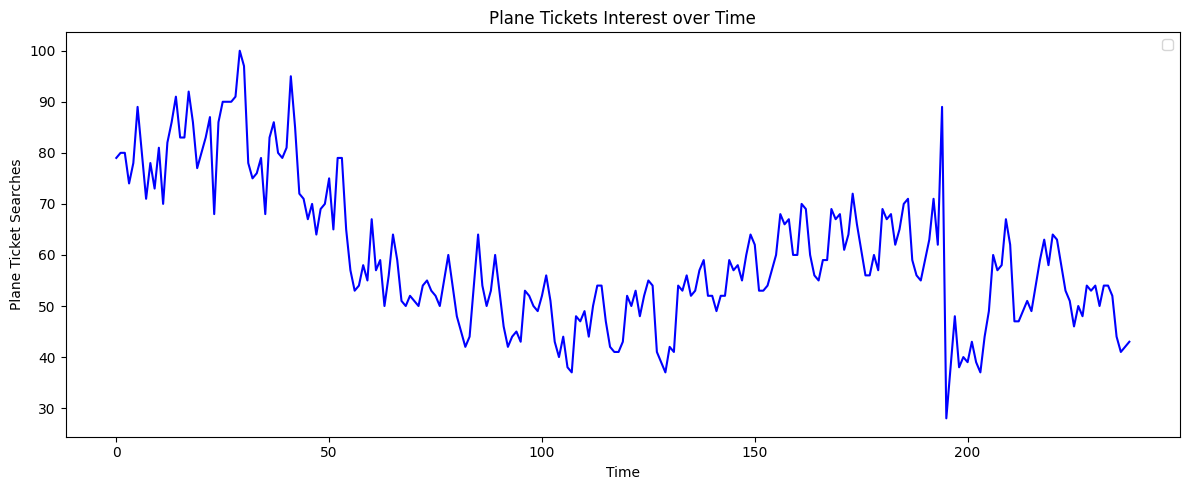

In [ ]:
plot_time_series(df=data, x="index", y="plane_tickets",
                 title="Plane Tickets Interest over Time",
                 xlabel="Time", ylabel="Plane Ticket Searches")

Upon initial look, this trend follows a roughly cyclical pattern. It is the later part of the report to model and evaluate this trend.

In addition, there appears to be a strong seasonal component to the data that repeats on a yearly or bi-yearly basis, since the visual graph shows consistent upward and downward pattern.

An anomaly happens in 2020, when there is a sudden dip.
A more careful approach to model the data before and after 2020 may be required to avoid influencing the forecasting by attributing too much significance to the 2020 global pandemic.

The 2008 recession was another period where plane ticket searches declined and the next few years saw the search trend overall going down.

The 2008 recession and 2020 pandemic contribute external events that provide a potential explanation for the changes in the time series model over time.

#### Breakdown of the distributions, by Year and Month

In [ ]:
# Again, this will be used several times, so we create a function to automate the process.

def distribution_breakdown(df, x, title):
    f, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

    # first plot: distribution by year
    sns.kdeplot(data=data, x=df[x], hue=df[title], ax=axs[0])

    # second plot: overall distribution
    sns.kdeplot(data, x=df["plane_tickets"], ax=axs[1])

    # layout
    plt.xlabel("Plane Ticket Search")
    plt.title(f"Distribution Breakdown by {title}")
    f.tight_layout()
    f.legend()
    plt.show()

In [ ]:
data.columns

Index(['time', 'plane_tickets', 'index', 'yy-mm', 'year', 'month'], dtype='object')

#### Breakdown by Year

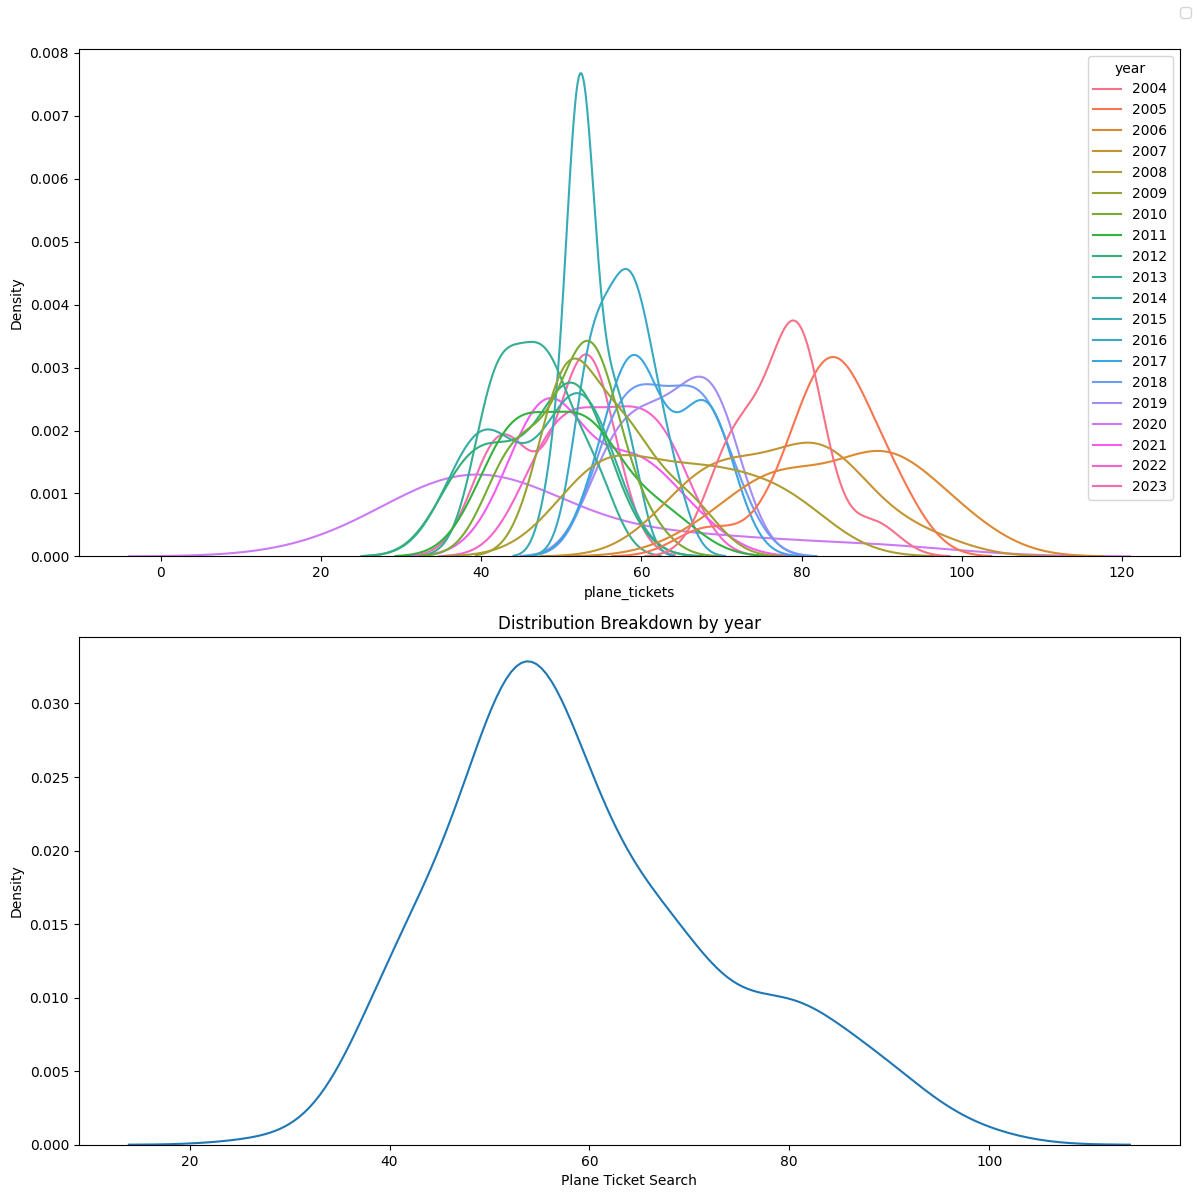

In [ ]:
distribution_breakdown(data, "plane_tickets", "year")

The Breakdown by Year shows a few interesting insights:

1. 2020 is a notable outlier. It has the widest distribution and shortest peak of all years, and most data points lie on the lower end of the spectrum.

2. 2015 and 2016 had the largest peaks and steepest distribution of all years.

3. 2004-2006 were the years where plane tickets search were hottest, as shown by distriutions that lie on the far right of the spectrum.

4. The overall distribution has a peak btween 50 and 60, likely 55. A smaller second peak appears after 80. Most data points lie between 40 and 80.



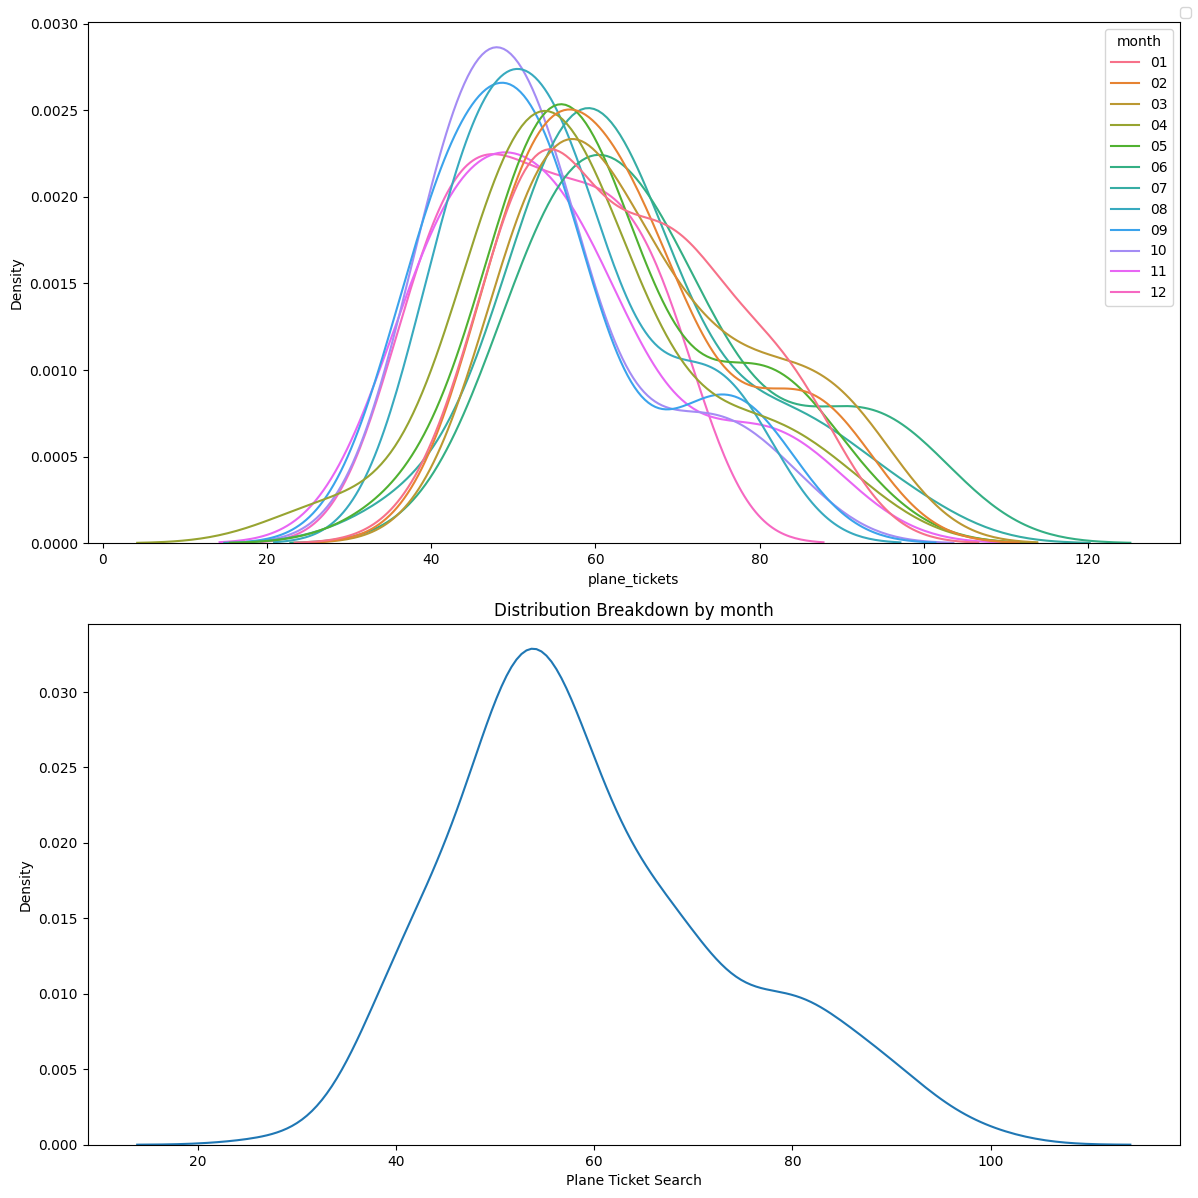

In [ ]:
distribution_breakdown(data, "plane_tickets", "month")

Breakdown of Months show a few interesting points:

1. June, July, Feburary, and January are the 4 months through 2004 - 2023 with larger plane ticket interest on Google Trends

2. July appears to have the largest spread. April comes close.

3. September has the most even distribution.  

4. August has the largest peak and steepest distribution but it is centered more toward the left (below 50)

5. Most of these distributions have 1 peak and 1 smaller peak


In [ ]:
from scipy.stats import norm

# create mu, sigma
mu, sigma = data.plane_tickets.mean(), data.plane_tickets.std()

# standardize data
data["z"] = data["plane_tickets"].apply(lambda x: (x-mu)/sigma)
# not this: np.random.normal(mu, sigma, 239)

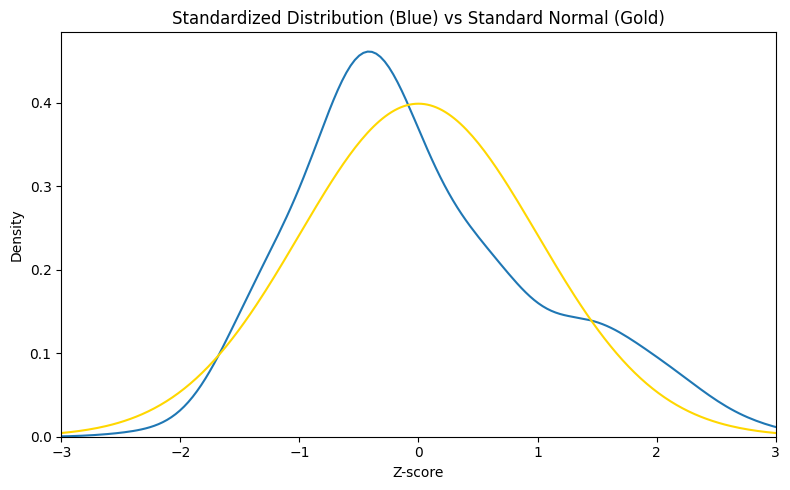

In [ ]:
# third plot: standardized z scores from data vs a normal distribution
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

# create mu, sigma
mu, sigma = 0, 1
# x-axis ranges from -3 and 3 with 239 steps
x = np.linspace(-3, 3, 239)

# not this: np.random.normal(mu, sigma, 239)

sns.kdeplot(data, x="z")
plt.plot(x, norm.pdf(x, 0, 1), color='gold')
ax.set_xlim(-3, 3)
plt.xlabel("Z-score")
plt.title("Standardized Distribution (Blue) vs Standard Normal (Gold)")
f.tight_layout()
plt.show()

This comparison shows that the overall distribution is not normal.

The standardized distribution is more right skewed than the standard normal distribution.

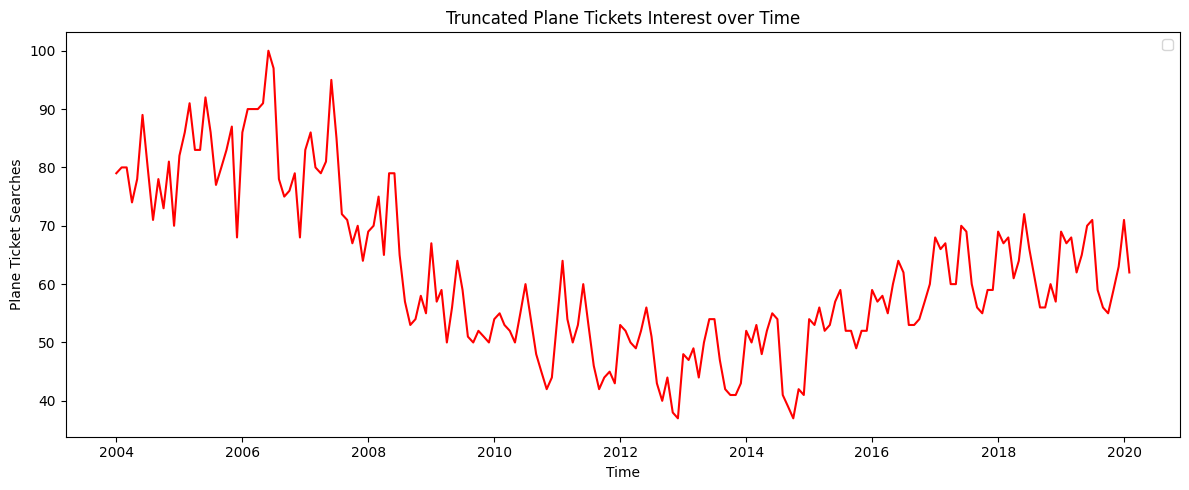

In [ ]:
# truncated data as an option to address covid spike, if we don't figure out dummy variables in time
data_tr = data.loc[0:193].copy(deep=True)


plot_time_series(df=data_tr, x="time", y="plane_tickets",
                 title="Truncated Plane Tickets Interest over Time",
                 xlabel="Time", ylabel="Plane Ticket Searches", color="red")

This data colored in red features the original data up until the Covid disturbance, but the variance in the first 50-60 time units may pose a problem for following analyses.

To reduce variance, utilize a log transformation.

log transformed

In [ ]:
# transformation to address variance
logdata_tr = data_tr.copy(deep=True)
logdata_tr["log plane tickets"] = np.log(data_tr["plane_tickets"])

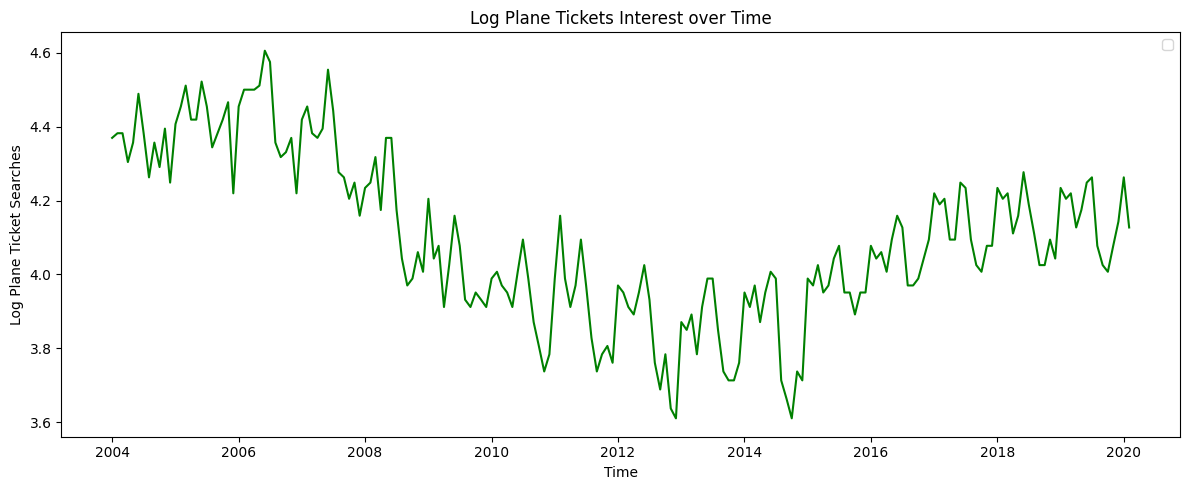

In [ ]:
plot_time_series(df=logdata_tr, x="time", y="log plane tickets",
                 title="Log Plane Tickets Interest over Time",
                 xlabel="Time", ylabel="Log Plane Ticket Searches", color="g")

# Initial ACF to identify period

In [ ]:
from statsmodels.tsa.stattools import acf, pacf, adfuller, arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

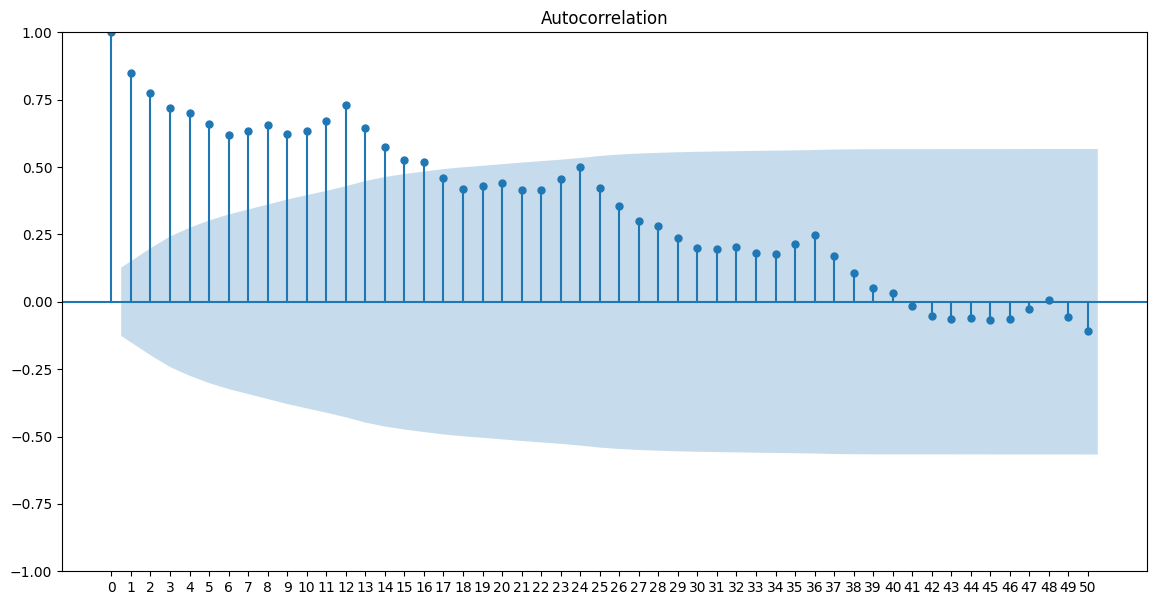

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))

plot_acf(data.plane_tickets.values.squeeze(), lags=50, ax=ax, title='Autocorrelation', use_vlines=True);
lags = list(range(51))
ax.set_xticks(lags);
ax.set_xticklabels(lags);

From the above ACF plot, the period appears to be 12. This should represent the months.

# Removing Trend and Seasonality

It is evident from the above graphs that the data is not stationary.

Before we continue with ACF and PACF plots, it's best that we remove the trend and seasonal components

#### transformed data

removing trend:

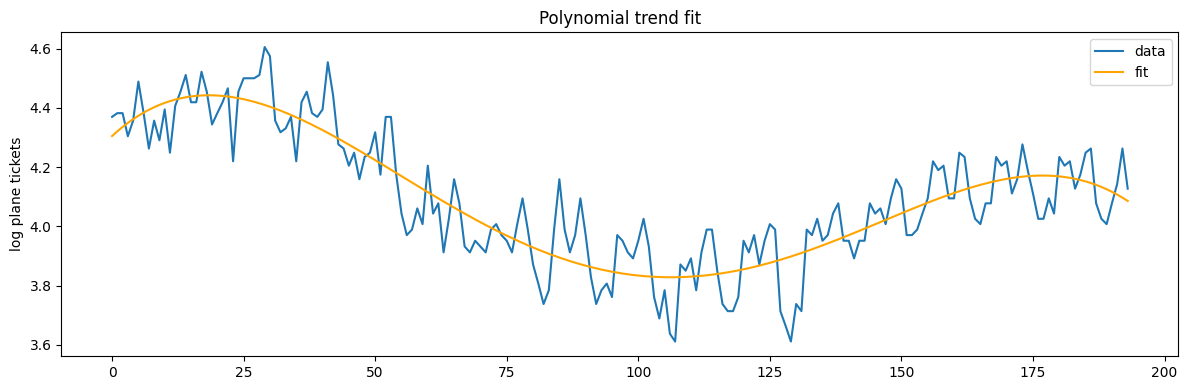

In [ ]:
trend_fit = np.polyfit(logdata_tr['index'].values, logdata_tr['log plane tickets'].values, 4)
trend = np.polyval(trend_fit, logdata_tr['index'])

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(logdata_tr['log plane tickets'], label='data')
sns.lineplot(trend, color = 'orange', label='fit')
plt.title("Polynomial trend fit")
plt.rc({'font.size': 16})
plt.tight_layout()
plt.show()

In [ ]:
logdata_tr["log_diff"] = logdata_tr['log plane tickets'].diff().fillna(0)

In [ ]:
trend_fit

array([-1.18856375e-08,  4.77704063e-06, -5.70253234e-04,  1.64300489e-02,
        4.30472473e+00])

Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
to points `(x, y)`. Returns a vector of coefficients `p` that minimises
the squared error in the order `deg`, `deg-1`, ... `0`.


#### seasonality:

In [ ]:
decompose = sd(logdata_tr["log_diff"], model='additive', period=12, two_sided=True, extrapolate_trend=0)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(logdata_tr['log plane tickets'], label='data')
sns.lineplot(decompose.seasonal+trend, color = 'orange', label='fit')
plt.title("Polynomial trend fit")
plt.rc({'font.size': 16})
plt.tight_layout()
plt.show()

In [ ]:
# decompose = sd(logdata_tr["log plane tickets"], model='additive', period=12, two_sided=True, extrapolate_trend=0)
decompose = sd(logdata_tr["log_diff"], model='additive', period=12, two_sided=True, extrapolate_trend=0)

#### differencing:

In [ ]:
logdata_tr['diff'] = logdata_tr['log_diff'] - decompose.seasonal

Above is the Covid-truncated data with the seasonality and trend components generated by seasonal_decompose() subtracted out.

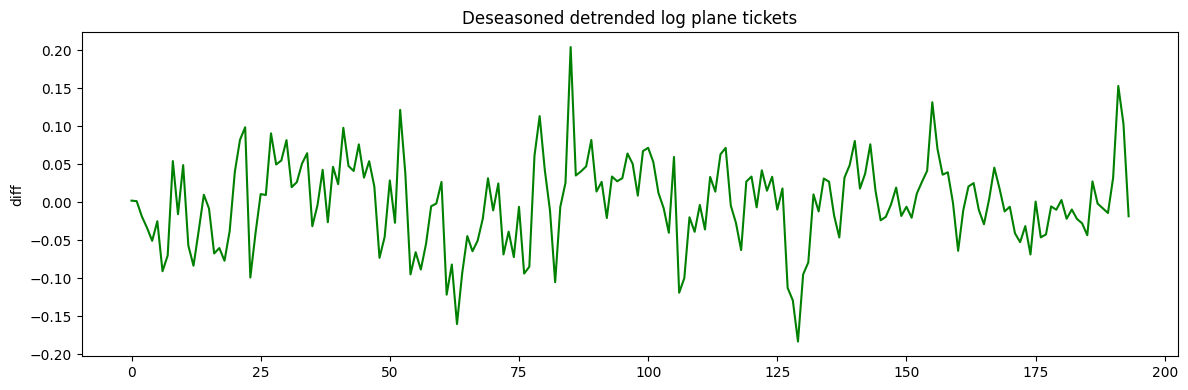

In [ ]:
### plotting transformed detrended deseasoned time series

# plot
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
plt.title("Deseasoned detrended log plane tickets")
sns.lineplot(logdata_tr['diff'], color = 'g')
plt.tight_layout()
plt.show()

Above is the log transformed data with the seasonality and trend components generated by seasonal_decompose() subtracted out.

# ACF and PACF

With the seasonality and trend removed, we look at $X_t$ and its autocorrelation plots below to see if any particular ARMA structure has emerged.

#### transformed data

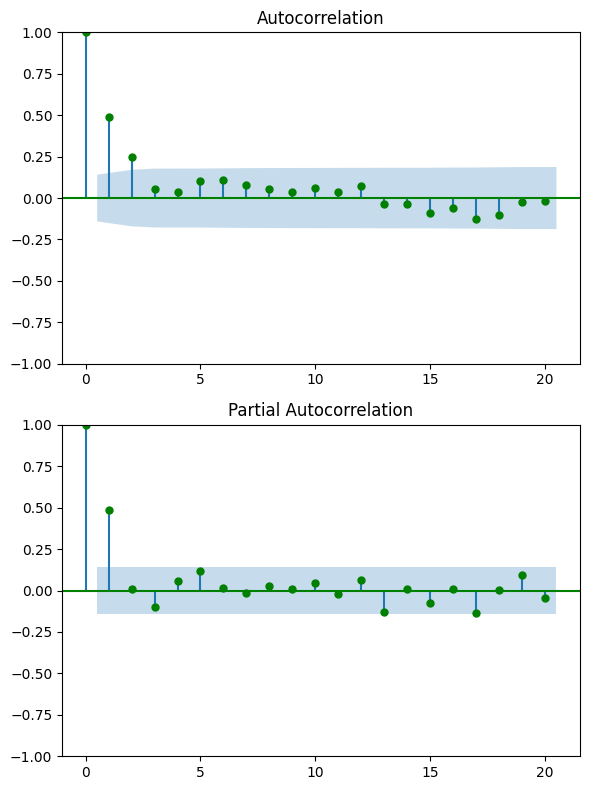

In [ ]:
# plots for transformed truncated data
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

plot_acf(logdata_tr["diff"],lags=20, ax=ax[0], color='g')
plot_pacf(logdata_tr["diff"],lags=20, ax=ax[1], method='ols', color='g')

plt.tight_layout()
plt.show()

The AR structure in the log-transformed de-seasonalized and de-trended autocorrelation plot is even more pronounced, and the dampening toward zero in the larger lags implies the series is now reasonably stationary, but a test will be carried out for stronger evidence of stationarity.

# Stationarity test

Adfuller Test:

```
Ho: Time series is non-stationary
Ha: Time series is stationary
```



Kpss Test:

```
Ho: Time series is Stationary
Ha: Time series is Non-Stationary
```



In [ ]:
from statsmodels.tsa.stattools import kpss as kp

In [ ]:
def adfuller_test(x):
  ad = adfuller(x)
  stat = ad[0]
  p = ad[1]
  truth = p < 0.05
  if truth == True:
    return [stat, p, "less than", "reject", "desired"]
  else:
    return [stat, p, "greater than", "fail to reject", "undesired"]

def kpss_test(x):
  k = kp(x)
  stat = k[0]
  p = k[1]
  truth = p < 0.05
  if truth == True:
    truth = "less than"
    return [stat, p, "less than", "reject", "undesired"]
  else:
    truth = "greater than"
    return [stat, p, "greater than", "fail to reject", "desired"]

In [ ]:
adfs = adfuller(logdata_tr["log_diff"].values)
adfs

(-2.310028127291018,
 0.1687540962687205,
 15,
 178,
 {'1%': -3.467631519151906,
  '5%': -2.8779183721695567,
  '10%': -2.575501353364474},
 -450.6747721776767)

In [ ]:
k = kpss(logdata_tr["log_diff"].values)
k

(0.49999999999999256,
 0.041666666666668344,
 193,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [ ]:
result_adfs = adfuller(logdata_tr["log_diff"].values)
result_kpss = kpss_test(logdata_tr["log_diff"].values)

print(f"ADF Stationarity (Adfuller test): Test Statistic is {result_adfs[0]}. \n Since p-value {result_adfs[1]} is {result_adfs[2]} significance level a = 0.05, we {result_adfs[3]} the null hypothesis\n\n")
print(f"KPSS Stationarity (Adfuller test): Test statistic is {result_kpss[0]}. \n Since p-value is {result_kpss[1]} is {result_kpss[2]} significance level a = 0.05, we {result_kpss[3]} the null hypothesis\n")

ADF Stationarity (Adfuller test): Test Statistic is -2.310028127291018. 
 Since p-value 0.1687540962687205 is 15 significance level a = 0.05, we 178 the null hypothesis


KPSS Stationarity (Adfuller test): Test statistic is 0.49999999999999256. 
 Since p-value is 0.041666666666668344 is less than significance level a = 0.05, we reject the null hypothesis



These 2 results above combined are desired outcomes, in which case we have determined stationarity.

# ARMA model

With the reasonable determination of $X_t$ as a stationary process, ARMA models of varying q and p parameters are fit and the one yielding the smallest AIC value is selected.

In [ ]:
from statsmodels.tsa.stattools import arma_order_select_ic

# AIC critereon model selection
model = arma_order_select_ic(logdata_tr["log_diff"], max_ar=4, max_ma=2, ic="aic")
model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

{'aic':             0           1           2
 0 -340.281591 -340.857198 -354.177384
 1 -339.907130 -361.212719 -362.191057
 2 -342.282979 -363.927418 -357.214150
 3 -359.459426 -358.090373 -376.305988
 4 -357.826880 -356.110301 -366.597591,
 'aic_min_order': (3, 2)}

To make an AMRA model, we use the ARIMA function from the statsmodels package. To make the ARIMA fit our ideal model, we set the differencing parameter d = 0, because we have already done our differencing before.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


# ARMA(3,1) tentative selection
model = ARIMA(logdata_tr["log_diff"], order=(1, 0, 0))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:               log_diff   No. Observations:                  194
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 172.954
Date:                Thu, 11 Jan 2024   AIC                           -339.907
Time:                        18:28:17   BIC                           -330.104
Sample:                             0   HQIC                          -335.937
                                - 194                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.007     -0.181      0.856      -0.014       0.012
ar.L1         -0.0915      0.076     -1.207      0.227      -0.240       0.057
sigma2         0.0098      0.001      9.634      0.0

The Ljung-Box p-value lends credence to this ARMA fit successfully capturing all but white noise in the residuals.

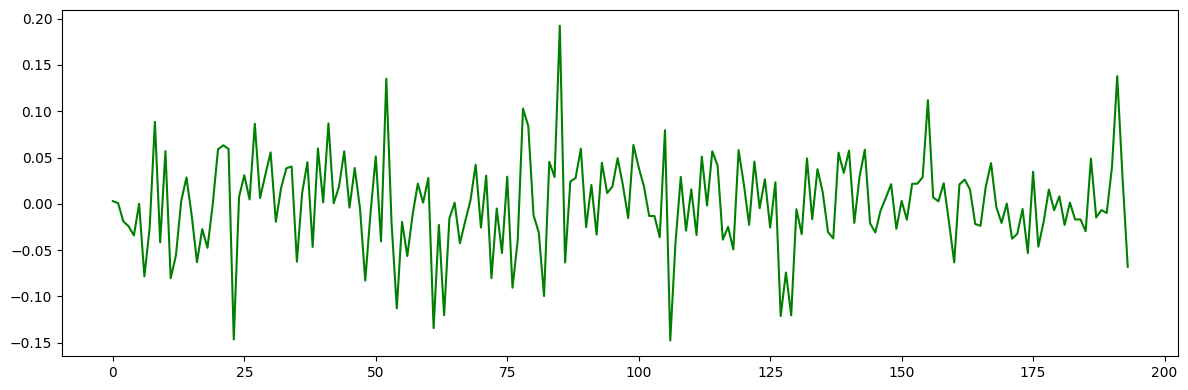

In [ ]:
# ARMA residuals

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(res.resid, color = 'g')
plt.tight_layout()
plt.show()

# Model Training and Prediction

Use the trend just before the Covid-19 to predict the future values. We aim to see if the prediction comes close to the reality or if it may smooth out the unexpected turmoil brought by the 2020 global pandemic.

The index at 2020 started roughly after 180, from basic inspection, so this number will be used as a cut-off value.

A useful detail is that to apply ARMA, we set statsmodel's ARIMA model with the parameter d = 0 because we have already applied differencing from before.

In [ ]:
# set a cut-off value
cutoff = 180

# training, testing set splits
train, test = logdata_tr["log_diff"].iloc[:cutoff], logdata_tr["log_diff"].iloc[cutoff:]

# prediction
predictions = list()

In [ ]:
from itertools import product
from tqdm import tqdm_notebook


ps = range(0, 6, 1)
d = 0
qs = range(0, 6, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 0)
    each = tuple(each)
    order_list.append(each)

#result_df = optimize_ARIMA(order_list)
#result_df

In [ ]:
def optimize_ARMA(order_list):
    """
        Return dataframe with parameters and corresponding AIC

        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(train, order=order).fit()
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
fitting = optimize_ARMA(order_list)

<ipython-input-49-ce93dbcd543c>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py

In [ ]:
fitting.head(10)

,"(p, d, q)",AIC
0,"(5, 0, 5)",-382.424273
1,"(5, 0, 3)",-373.904924
2,"(3, 0, 4)",-357.890640
3,"(3, 0, 3)",-357.303180
4,"(4, 0, 5)",-351.809382
5,"(4, 0, 3)",-351.591075
6,"(4, 0, 4)",-350.915822
7,"(2, 0, 2)",-348.703598
8,"(1, 0, 5)",-348.480591
9,"(5, 0, 4)",-345.266923


The best model with summary

In [ ]:
best_model = ARIMA(train, order=(5,0,5)).fit()
print(best_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:               log_diff   No. Observations:                  180
Model:                 ARIMA(5, 0, 5)   Log Likelihood                 203.212
Date:                Thu, 11 Jan 2024   AIC                           -382.424
Time:                        18:32:24   BIC                           -344.109
Sample:                             0   HQIC                          -366.889
                                - 180                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.565      0.572      -0.006       0.003
ar.L1          0.6657      0.075      8.921      0.000       0.519       0.812
ar.L2         -0.1450      0.066     -2.212      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Study the Residual

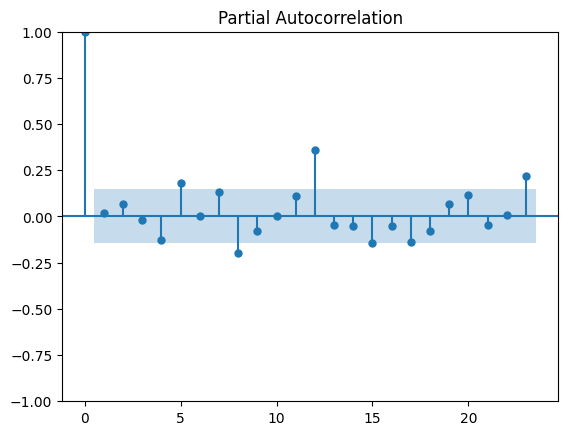

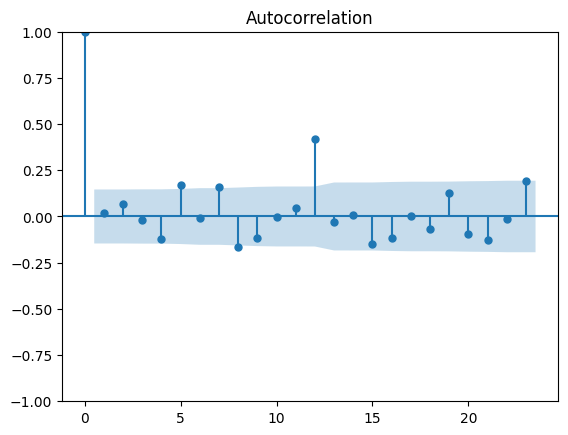

In [ ]:
plot_pacf(best_model.resid);
plot_acf(best_model.resid);

Given that both PACF and ACF give plots that resemble white noise, we are confident that the model is ready to go for forecasting!

But before we do so, it may be constructive to compare the prediction results with the actual data that happened after the events of 2020.

In [ ]:
logdata_tr["diff_pred"] = best_model.predict(start = 180, end = 239)
logdata_tr["full_pred"] = best_model.predict(start = 0, end = 239)

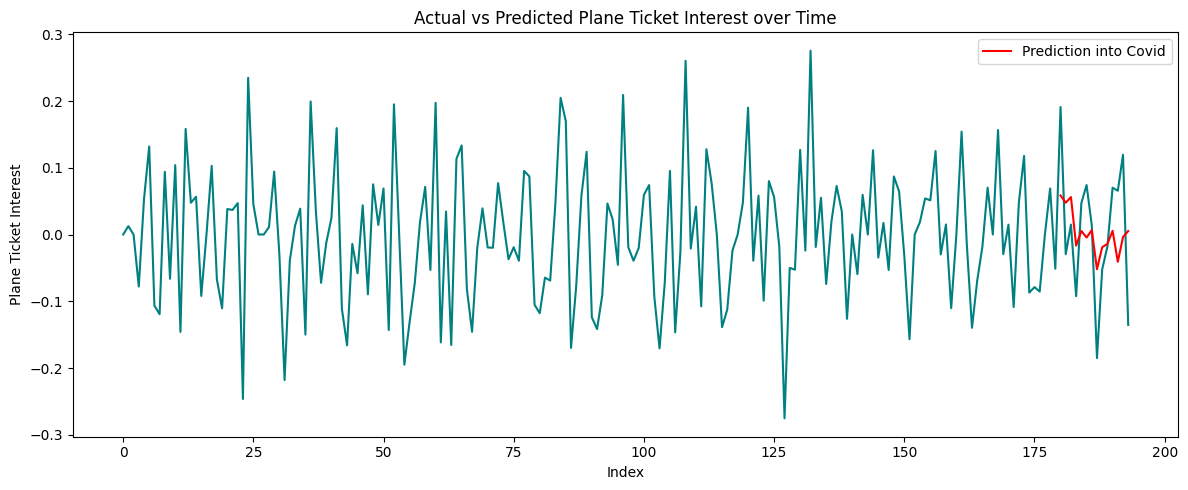

In [ ]:
plot_time_series(logdata_tr, 'index', 'log_diff', '', 'Index', 'Plane Ticket Interest',
                 True, 'diff_pred', 'Prediction into Covid', 'teal')

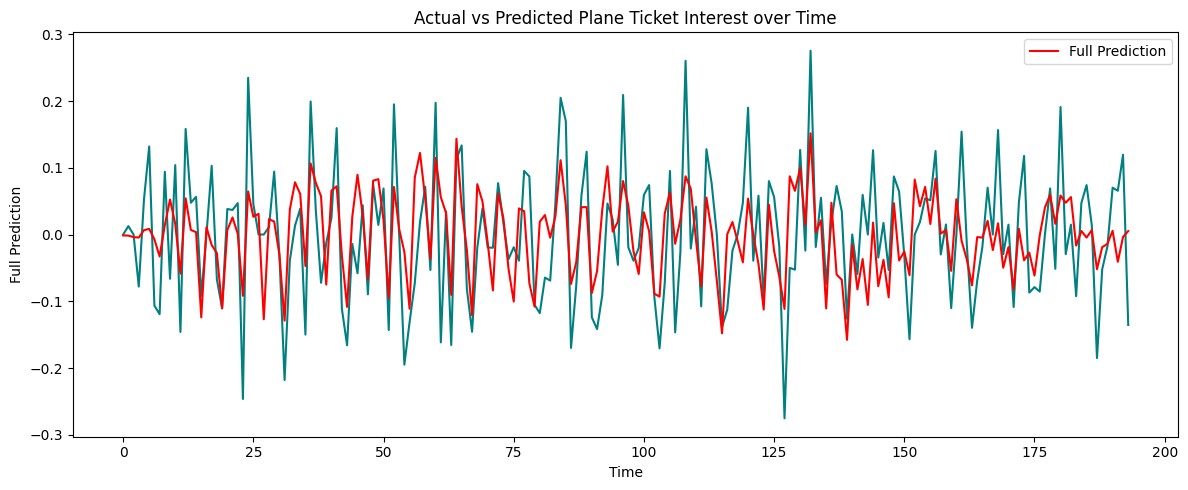

In [ ]:
plot_time_series(logdata_tr, 'index', 'log_diff', '', 'Time', 'Full Prediction', True, 'full_pred', "Full Prediction",'teal')

In [ ]:
predictions = pd.Series(best_model.forecast(len(test)))
print(predictions.head())

180    0.058493
181    0.047597
182    0.056127
183   -0.016606
184    0.005389
Name: predicted_mean, dtype: float64


Interestingly, the prediction smoothes out the fluctuations to a great extent. Its prediction over Covid just hovers just slightly above and below 0.

While on the mark, the prediction can be more constructive,if we convert it back to the original scale so we can compare to the original time series as is.

This way, we can see what values the time series predicts, with all the seasonality and trend that come into play.

We have to reverse the detrending and deseasonalizing process to get back the original.





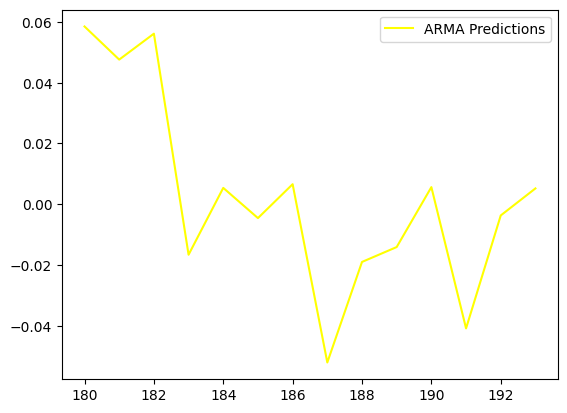

In [ ]:
y_pred = best_model.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = best_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]
plt.plot(y_pred_out, color='Yellow', label = 'ARMA Predictions')
plt.legend()

In [ ]:
data.columns

Index(['time', 'plane_tickets', 'index', 'yy-mm', 'year', 'month', 'z',
       'pred_cumsum_add_exp'],
      dtype='object')

#### Our failed (!!) attempt to do something fancy with the output...didn't come out expected.

In [ ]:
"""
preds = pd.Series(logdata_tr["full_pred"].values, copy=True)
pred_cumsum = preds.cumsum()
"""

In [ ]:
add_to_pred_cumsum = logdata_tr["full_pred"] + trend + decompose.seasonal
add_to_pred_cumsum

0      4.365940
1      4.380916
2      4.400718
3      4.328036
4      4.389576
         ...   
189    4.020652
190    4.039978
191    3.989631
192    4.161074
193    4.142213
Length: 194, dtype: float64

In [ ]:
logdata_tr["final_pred"] = np.exp(add_to_pred_cumsum)
logdata_tr["orig"] = data["plane_tickets"]

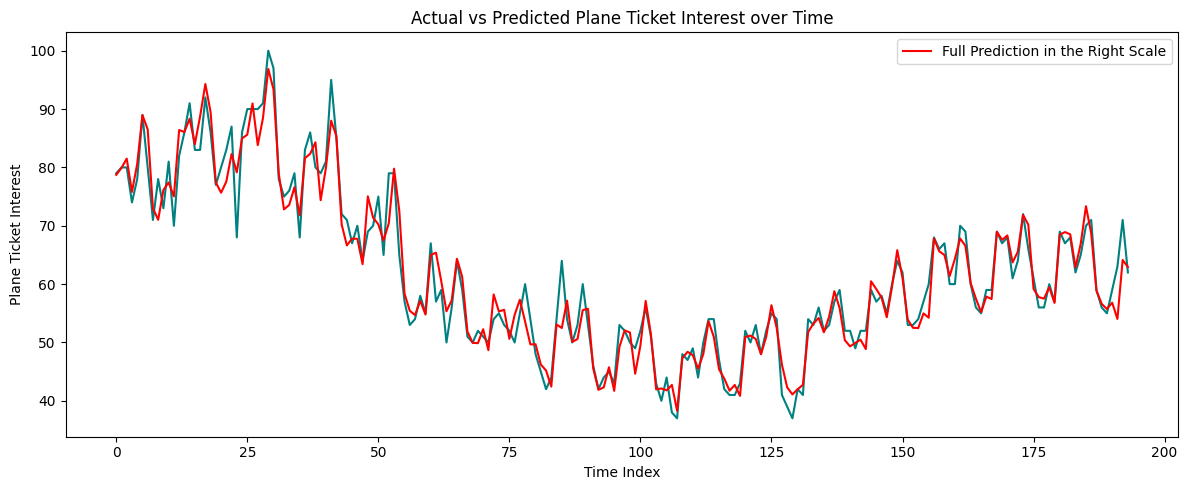

In [ ]:
plot_time_series(logdata_tr, 'index', 'orig', '', 'Time Index', 'Plane Ticket Interest', True,
                 "final_pred", "Full Prediction in the Right Scale",'teal')

Spectral Analysis

In [ ]:
!pip install spectrum

<Axes: >

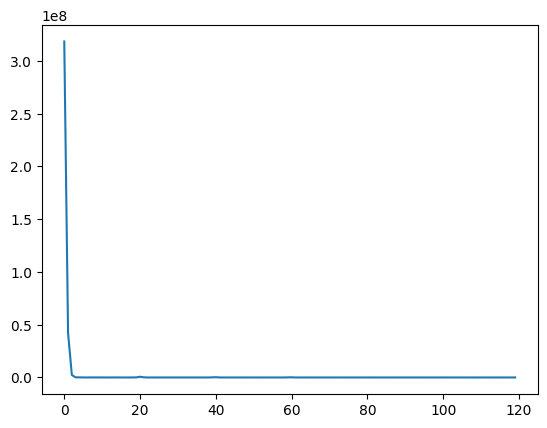

In [ ]:
from spectrum import speriodogram, marple_data


p = speriodogram(data.plane_tickets)
sns.lineplot(p)

/usr/local/lib/python3.10/dist-packages/spectrum/periodogram.py:311: RuntimeWarning: invalid value encountered in double_scalars
  newpsd[i] /= float(count)


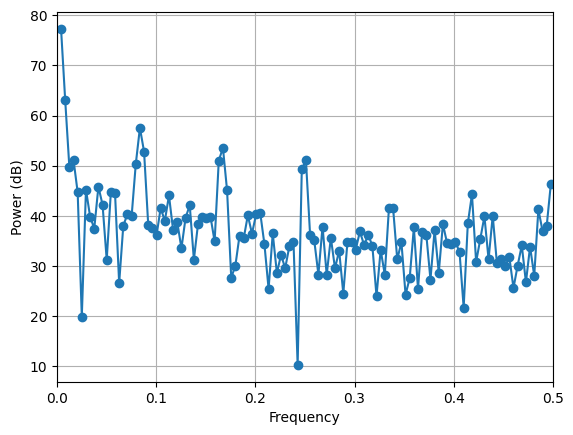

In [ ]:
from spectrum import data_cosine, pdaniell


#data = data_cosine(data.plane_tickets, N=239)

p = pdaniell(data.plane_tickets, 0, NFFT=239)
p.plot(marker='o')